Kaggle Dataset Link: https://www.kaggle.com/competitions/gan-getting-started

Irwindeep Kaggle Notebook to play with  
link: https://www.kaggle.com/code/irwindeep/monet2photo-cyclegan

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras import layers, ops
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import shutil
import zipfile
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import io
from functools import partial
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchinfo import summary
from typing import List, Tuple, Any, Callable, Optional

plt.rcParams.update({"font.family": "monospace"})
torch.manual_seed(42)

In [11]:
class Monet2Photo(Dataset):
    def __init__(
        self,
        root_monet: str,
        root_photo: str,
        transform: Optional[Callable] = None,
        dataset_size: Optional[int] = None
    ) -> None:
        self.root_monet = root_monet
        self.root_photo = root_photo
        self.transform = transform

        self.monet_paths = os.listdir(self.root_monet)[:dataset_size]
        self.photo_paths = os.listdir(self.root_photo)[:dataset_size]

        self.monet_paths = [os.path.join(root_monet, p) for p in self.monet_paths]
        self.photo_paths = [os.path.join(root_photo, p) for p in self.photo_paths]

        self.dataset_len = max(len(self.monet_paths), len(self.photo_paths))

    def __len__(self) -> int:
        return self.dataset_len

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        monet_path = self.monet_paths[idx % len(self.monet_paths)]
        photo_path = self.photo_paths[idx % len(self.photo_paths)]

        monet = Image.open(monet_path)
        photo = Image.open(photo_path)

        if self.transform:
            monet = self.transform(monet)
            photo = self.transform(photo)

        return monet, photo

Dataset Size: 500


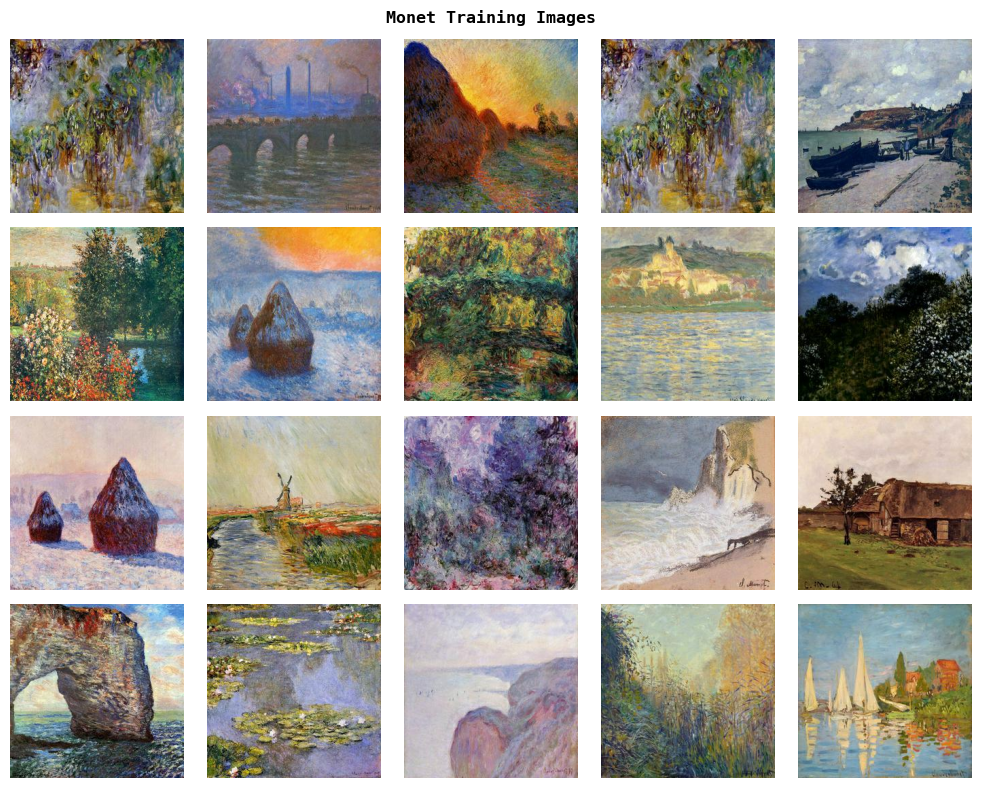

In [14]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
inv_norm = transforms.Normalize((-1, -1, -1), (2, 2, 2))

train_dataset = Monet2Photo(
    root_monet="gan-getting-started/monet_jpg",
    root_photo="gan-getting-started/photo_jpg",
    transform=transform,
    dataset_size=500
)

print(f"Dataset Size: {len(train_dataset):,}")
rows, cols = 4, 5
indices = torch.randint(0, len(train_dataset)-1, size=(rows*cols,)).numpy()

fig = plt.figure(figsize=(10, 8))
fig.suptitle("Monet Training Images", fontweight="bold")
for i, idx in enumerate(indices, start=1):
    monet, _ = train_dataset[idx]
    monet_np = inv_norm(monet).numpy().transpose(1, 2, 0)

    plt.subplot(rows, cols, i)
    plt.imshow(monet_np)
    plt.axis("off")

plt.tight_layout()
plt.show()


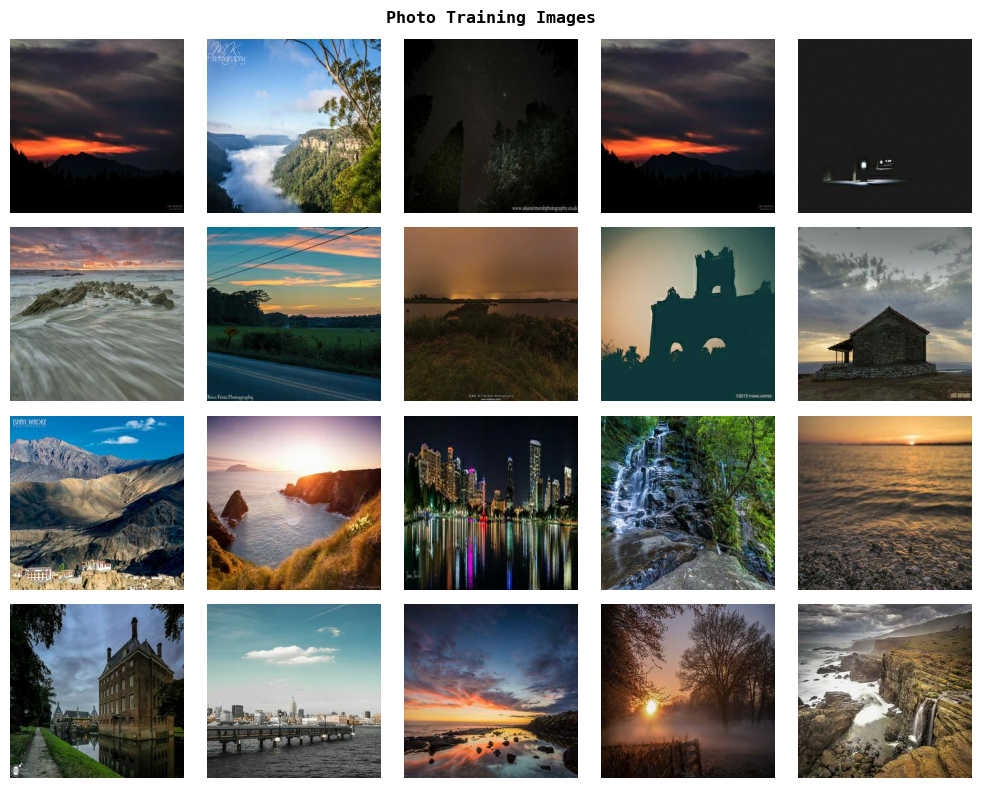

In [15]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle("Photo Training Images", fontweight="bold")
for i, idx in enumerate(indices, start=1):
    _, photo = train_dataset[idx]
    photo_np = inv_norm(photo).numpy().transpose(1, 2, 0)

    plt.subplot(rows, cols, i)
    plt.imshow(photo_np)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

print(f"# Train Batches: {len(train_loader)}")

# Train Batches: 125


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [18]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        act: Optional[str] = "relu"
    ) -> None:
        super(ConvBlock, self).__init__()

        activation = (
            {
                "relu": partial(nn.ReLU, inplace=True),
                "leaky_relu": partial(nn.LeakyReLU, 0.2, inplace=True)
            }.get(act, partial(nn.ReLU, inplace=True))
            if act else None
        )
        modules = [
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride=stride,
                padding=padding,
                padding_mode="reflect"
            ),
            nn.InstanceNorm2d(out_channels)
        ]
        if activation: modules.append(activation())

        self.conv = nn.Sequential(*modules)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.conv(input)

In [19]:
class UpsampleBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0
    ) -> None:
        super(UpsampleBlock, self).__init__()

        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            ),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.upconv(input)

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int) -> None:
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, kernel_size=3, padding=1, act=None)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input + self.block(input)

In [22]:
class Generator(nn.Module):
    def __init__(self, num_features: int, num_blocks: int) -> None:
        super(Generator, self).__init__()

        self.initial = ConvBlock(3, num_features, kernel_size=7, padding=3)
        self.down_proj = nn.Sequential(
            ConvBlock(num_features, num_features*2, kernel_size=4, stride=2, padding=1),
            ConvBlock(num_features*2, num_features*4, kernel_size=4, stride=2, padding=1)
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_features*4) for _ in range(num_blocks)])
        self.up_proj = nn.Sequential(
            UpsampleBlock(num_features*4, num_features*2, kernel_size=4, stride=2, padding=1),
            UpsampleBlock(num_features*2, num_features, kernel_size=4, stride=2, padding=1)
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_features, 3, kernel_size=7, padding=3, padding_mode="reflect"),
            nn.Tanh()
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = self.initial(input)
        output = self.down_proj(output)
        output = self.res_blocks(output)
        output = self.up_proj(output)
        output = self.final(output)

        return output

class Discriminator(nn.Module):
    def __init__(self, channels: List[int]) -> None:
        super(Discriminator, self).__init__()

        in_channs, out_channs = channels[:-1], channels[1:]
        self.model = nn.Sequential(*[
            ConvBlock(in_chann, out_chann, kernel_size=4, stride=2, padding=1, act="leaky_relu")
            for in_chann, out_chann in zip(in_channs, out_channs)
        ])
        self.final = nn.Sequential(
            nn.Conv2d(out_channs[-1], 1, kernel_size=4, padding=1, padding_mode="reflect"),
            nn.Sigmoid()
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = self.model(input)
        output = self.final(output)

        return output

In [23]:
gen_m = Generator(num_features=64, num_blocks=6).to(device)
gen_p = Generator(num_features=64, num_blocks=6).to(device)

disc_m = Discriminator(channels=[3, 64, 128, 256, 512]).to(device)
disc_p = Discriminator(channels=[3, 64, 128, 256, 512]).to(device)

In [24]:
summary(gen_m, (batch_size, 3, 256, 256), depth=2)

Layer (type:depth-idx)                                  Output Shape              Param #
Generator                                               [4, 3, 256, 256]          --
├─ConvBlock: 1-1                                        [4, 64, 256, 256]         --
│    └─Sequential: 2-1                                  [4, 64, 256, 256]         9,472
├─Sequential: 1-2                                       [4, 256, 64, 64]          --
│    └─ConvBlock: 2-2                                   [4, 128, 128, 128]        131,200
│    └─ConvBlock: 2-3                                   [4, 256, 64, 64]          524,544
├─Sequential: 1-3                                       [4, 256, 64, 64]          --
│    └─ResidualBlock: 2-4                               [4, 256, 64, 64]          1,180,160
│    └─ResidualBlock: 2-5                               [4, 256, 64, 64]          1,180,160
│    └─ResidualBlock: 2-6                               [4, 256, 64, 64]          1,180,160
│    └─ResidualBlock: 2-7 

In [25]:
summary(disc_m, (batch_size, 3, 256, 256), depth=2)

Layer (type:depth-idx)                        Output Shape              Param #
Discriminator                                 [4, 1, 15, 15]            --
├─Sequential: 1-1                             [4, 512, 16, 16]          --
│    └─ConvBlock: 2-1                         [4, 64, 128, 128]         3,136
│    └─ConvBlock: 2-2                         [4, 128, 64, 64]          131,200
│    └─ConvBlock: 2-3                         [4, 256, 32, 32]          524,544
│    └─ConvBlock: 2-4                         [4, 512, 16, 16]          2,097,664
├─Sequential: 1-2                             [4, 1, 15, 15]            --
│    └─Conv2d: 2-5                            [4, 1, 15, 15]            8,193
│    └─Sigmoid: 2-6                           [4, 1, 15, 15]            --
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 6.66
Input size (MB): 3.15
Forward/backward pass size (MB): 62.92
Params size (MB): 11.06
Estimated Total Size 

In [26]:
mse = nn.MSELoss()
l1 = nn.L1Loss()

def train_epoch(
    generators: List[nn.Module],
    discriminators: List[nn.Module],
    train_loader: DataLoader[torch.Tensor],
    optimizers: List[torch.optim.Optimizer],
    desc: str,
    lmbd_cycle: float = 10.0,
    lmbd_identity: float = 5.0
) -> Tuple[float, float]:
    gen_m, gen_p = tuple(generators)
    disc_m, disc_p = tuple(discriminators)

    optim_g, optim_d = tuple(optimizers)
    
    gen_m.train()
    gen_p.train()
    disc_m.train()
    disc_p.train()

    gen_loss, disc_loss = 0.0, 0.0
    num_batches = len(train_loader)

    pbar = tqdm(train_loader, desc=desc)
    for batch, (Xr_m, Xr_p) in enumerate(pbar, start=1):
        Xr_m = Xr_m.to(device)
        Xr_p = Xr_p.to(device)

        Xf_m = gen_m(Xr_p) # monet from photo
        Xf_p = gen_p(Xr_m) # photo from monet

        # training both discriminators
        Dr_m, Dr_p = disc_m(Xr_m), disc_p(Xr_p)
        Df_m, Df_p = disc_m(Xf_m.detach()), disc_p(Xf_p.detach())

        loss_dm = mse(Dr_m, torch.ones_like(Dr_m)) + mse(Df_m, torch.zeros_like(Df_m))
        loss_dp = mse(Dr_p, torch.ones_like(Dr_p)) + mse(Df_p, torch.zeros_like(Df_p))

        loss_d = (loss_dm + loss_dp)/2
        optim_d.zero_grad()
        loss_d.backward()
        optim_d.step()

        # training both generators
        ## adversarial loss
        Df_m, Df_p = disc_m(Xf_m), disc_p(Xf_p)
        loss_adv = mse(Df_m, torch.ones_like(Df_m)) + mse(Df_p, torch.ones_like(Df_p))

        ## cycle consistency loss
        C_m, C_p = gen_m(Xf_p), gen_p(Xf_m)
        loss_cyc = l1(C_m, Xr_m) + l1(C_p, Xr_p)

        ## identity loss
        loss_iden = 0.0
        if lmbd_identity >= 0.0:
            I_m, I_p = gen_m(Xr_m), gen_p(Xr_p)
            loss_iden = l1(I_m, Xr_m) + l1(I_p, Xr_p)

        loss_g = loss_adv + lmbd_cycle*loss_cyc + lmbd_identity*loss_iden
        optim_g.zero_grad()
        loss_g.backward()
        optim_g.step()

        gen_loss += loss_g.item()
        disc_loss += loss_d.item()

        pbar.set_postfix({
            "Generator Loss": f"{gen_loss/batch:.4f}",
            "Discriminator Loss": f"{disc_loss/batch:.4f}"
        })

    pbar.close()
    return gen_loss/num_batches, disc_loss/num_batches

In [27]:
epochs, lr = 100, 2e-4

optim_g = torch.optim.Adam(
    list(gen_m.parameters()) + list(gen_p.parameters()),
    lr=lr,
    betas=(0.5, 0.999)
)
optim_d = torch.optim.Adam(
    list(disc_p.parameters()) + list(disc_m.parameters()),
    lr=lr,
    betas=(0.5, 0.999)
)

In [ ]:
gen_losses, disc_losses = [], []
for epoch in range(1, epochs+1):
    desc = f"Epoch [{epoch:03d}/{epochs}]"
    gen_loss, disc_loss = train_epoch(
        generators=[gen_m, gen_p],
        discriminators=[disc_m, disc_p],
        train_loader=train_loader,
        optimizers=[optim_g, optim_d],
        desc=desc,
        lmbd_identity=0.0
    )

    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

Epoch [001/100]:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(gen_losses)+1), gen_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss-Epoch Distribution", fontweight="bold")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(disc_losses)+1), disc_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss-Epoch Distribution", fontweight="bold")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
gen_m.eval()

fig = plt.figure(figsize=(10, 8))
fig.suptitle("Generated Monet Images", fontweight="bold")
for i, idx in enumerate(indices, start=1):
    _, photo = train_dataset[i]
    with torch.no_grad():
        monet = gen_m(photo.to(device)).cpu()
    monet_np = inv_norm(monet).numpy().transpose(1, 2, 0)

    plt.subplot(rows, cols, i)
    plt.imshow(monet_np)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
dataset = Monet2Photo(
    root_monet="gan-getting-started/monet_jpg",
    root_photo="gan-getting-started/photo_jpg",
    transform=transform,
)

with zipfile.ZipFile("images.zip", 'w') as zipf:
    for i in tqdm(range(len(dataset)), desc="Generating Submission"):
        _, photo = dataset[i]
        with torch.no_grad():
            monet = gen_m(photo.to(device)).cpu()
        monet_np = inv_norm(monet).numpy().transpose(1, 2, 0)
        monet_np = (255 * monet_np).astype(np.uint8)

        image = Image.fromarray(monet_np)
        buffer = io.BytesIO()
        image.save(buffer, format="JPEG")
        
        zipf.writestr(f"{i+1:04d}.jpg", buffer.getvalue())